<a href="https://colab.research.google.com/github/SamiHaddouti/Machine-Learning-Project/blob/main/DataExploration_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import dependencies

In [2]:
!pip install mlflow
!pip install pickle5
!pip install pyyaml==5.4.1

     |████████████████████████████████| 16.5 MB 5.1 MB/s 
     |████████████████████████████████| 210 kB 34.0 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
     |████████████████████████████████| 181 kB 33.6 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 146 kB 34.4 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 63 kB 787 kB/s 
     |████████████████████████████████| 78 kB 2.4 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.4-py3-none-any.whl size=106877 sha256=74cdd3b3b247126d4b1ba3a213a6140310172e0f91eecad68cf09689a74b3f69
  Stored in directory: /root/.cache/pip/wheels/a2/a1/6d/fa1d22ea25ed8593887437fe1c7e00f6ef307fc240ccd4dc5c
Successfully built databricks-cli
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [3]:
import json
from urllib.request import urlopen
import random
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import plotly.express as px
import mlflow
import mlflow.sklearn
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
import pickle5 as pickle

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Load data and set global variables

In [4]:
# Change!!!! to new Github
runs_df = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/output/runs.csv')
melb_df = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/input/melb_data.csv')
final_df = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/output/final_df.csv')
X_train = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/output/X_train.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/output/y_train.csv').values.ravel()
X_val = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/output/X_val.csv')
y_val = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/output/y_val.csv').values.ravel()
X_test = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/output/X_test.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/data/output/y_test.csv').values.ravel()
ml_run = 'https://github.com/SamiHaddouti/Machine-Learning-Project/blob/main/mlruns.zip'

mapbox_pub_token = 'pk.eyJ1IjoibWFyZXRoeXUiLCJhIjoiY2ttbjdmdzVsMDVvdjJxb2N3Njg0OHFpdiJ9.zqh3ey7Ux-yAfA-fJJPADA'

print(len(X_train))
print(len(X_val))
print(len(X_test))

3870
683
506


In [5]:
# Get mlrun model and unzip it
!wget https://github.com/SamiHaddouti/Machine-Learning-Project/raw/main/mlruns.zip
!unzip /content/mlruns.zip

# Get GeoJSON
# Original link to GeoJSON:
#with urlopen('https://data.gov.au/geoserver/vic-suburb-locality-boundaries-psma-administrative-boundaries/wfs?request=GetFeature&typeName=ckan_af33dd8c_0534_4e18_9245_fc64440f742e&outputFormat=json') as response:
#    suburbs = json.load(response)
!wget https://github.com/SamiHaddouti/Machine-Learning-Project/raw/main/data/input/Victoria_suburb_geoJSON.json.zip
!unzip /content/Victoria_suburb_geoJSON.json.zip

--2022-03-16 07:33:07--  https://github.com/SamiHaddouti/Machine-Learning-Project/raw/main/mlruns.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/mlruns.zip [following]
--2022-03-16 07:33:07--  https://raw.githubusercontent.com/SamiHaddouti/Machine-Learning-Project/main/mlruns.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58165487 (55M) [application/zip]
Saving to: ‘mlruns.zip’

mlruns.zip          100%[===================>]  55.47M   204MB/s    in 0.3s    

2022-03-16 07:33:08 (204 MB/s) - ‘mlruns.zip’ saved [58165487/58165487]

Archive:  /co

## Helper functions

In [6]:
# Evaluate metrics of model 
def eval_model(y_val, y_pred):
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    metrics = {
        "mae" : mae,
        "mse" : mse,
        "rmse" : rmse,
        "r2" : r2
        }

    return metrics
  
# Calculate how close a feature value is compared to the mean of the feature
def calc_prob(row):
  b_area_compared = round((row['BuildingArea'] / final_df['BuildingArea'].mean() - 1) * 100)
  distance_compared = round(row['Distance'] - final_df['Distance'].mean(), 1) 
  rooms_compared = round(row['Rooms'] - round(final_df['Rooms'].mean()))
  return [b_area_compared, distance_compared, rooms_compared]

# Helper function to support print statements (e.g. check for positive/negative values)
def check_pos_neg(number, option):
  if number == 0:
    return ', therefore, same as'
  elif number > 0:
    if option == 0:
      return ' above'
    else:
      return ' higher than'
  else:
    if option == 0:
      return ' below'
    else:
      return ' lower than'

# **Data Exploration**

# Heatmap of Melbourne housing market

In [ ]:
# Filter out extreme price outliers for visualization purposes
low_q = final_df['Price'].quantile(0.001)
high_q = final_df['Price'].quantile(0.999)

vis_df = final_df[(final_df['Price'] > low_q) & (final_df['Price'] < high_q)]

fig_hm = px.density_mapbox(vis_df, lat='Latitude', lon='Longitude', z='Price', radius=13,
                        center=dict(lat=-37.8, lon=145), zoom=9.75, height = 600, width = 1000,
                        mapbox_style='streets', title = 'Melbourne Housing - heatmap')
fig_hm.update_layout(mapbox_accesstoken=mapbox_pub_token)

fig_hm.show()
fig_hm.write_html("Heatmap_choropleth.html")

# Average cost for housing by suburbs

In [ ]:
# Data Preparation

# Add new column with mean suburb price
suburb_mean_price = melb_df.groupby('Suburb')['Price'].mean()
suburb_df = suburb_mean_price.reset_index()

# Capitalize all Suburb names like in GeoJSON
suburb_df['Suburb'] = suburb_df['Suburb'].apply(lambda x: x.upper())

f = open('Victoria_suburb_geoJSON.json')
suburbs = json.load(f)

# Only cover melbourne suburbs
suburbs['features'] = [x for x in suburbs['features'] if x['properties']['vic_loca_2'] in suburb_df['Suburb'].unique()]


In [ ]:
fig_suburbs = px.choropleth_mapbox(suburb_df, 
                                   locations='Suburb', 
                                   color='Price', 
                                   center=dict(lat=-37.8, lon=145), 
                                   zoom=9.75,  
                                   height = 600,
                                   width = 1000,
                                   geojson=suburbs, 
                                   featureidkey='properties.vic_loca_2',
                                   #featureidkey= 'properties.lc_ply_pid',
                                   title='Mean suburb property prices',
                                   mapbox_style='streets')
fig_suburbs.update_layout(mapbox_accesstoken=mapbox_pub_token)
fig_suburbs.show()
fig_suburbs.write_html("Suburbs_choropleth.html")

# Load the model

In [7]:
run_id = 'ed0dd55d46d74016bb86835c04de4acc'
#loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/final_model")
#loaded_model = mlflow.sklearn.load_model(f"runs:/{run_id}/final_model")
loaded_model = pickle.load(open(f'mlruns/1/{run_id}/artifacts/final_model/model.pkl', 'rb'))

#y_pred = loaded_model.predict(X_val)
#metrics = eval_model(y_val, y_pred)
#print(metrics)

# Learning curve

In [13]:
learning_curve(loaded_model, X_val, y_val, scoring='r2')

(array([ 54, 177, 300, 423, 546]),
 array([[0.8946041 , 0.86761232, 0.86761232, 0.86761232, 0.86761232],
        [0.91805094, 0.91001311, 0.91690768, 0.91690768, 0.91690768],
        [0.92568666, 0.92910317, 0.9193653 , 0.91741188, 0.91741188],
        [0.92162218, 0.92319515, 0.91622222, 0.92847769, 0.92961807],
        [0.93083844, 0.93374315, 0.92864612, 0.93792339, 0.92545969]]),
 array([[0.62963658, 0.45537773, 0.53332527, 0.50491153, 0.53751692],
        [0.67621607, 0.63643602, 0.70815754, 0.61738722, 0.76892737],
        [0.73163601, 0.70447839, 0.74964664, 0.66781258, 0.8017134 ],
        [0.73658934, 0.7183838 , 0.75490394, 0.68411651, 0.82671625],
        [0.75171404, 0.73159015, 0.76378985, 0.7062595 , 0.82483669]]))

In [17]:
train_sizes, train_scores, test_scores = learning_curve(loaded_model, X_train, y_train, scoring='r2', train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


KeyboardInterrupt: ignored

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

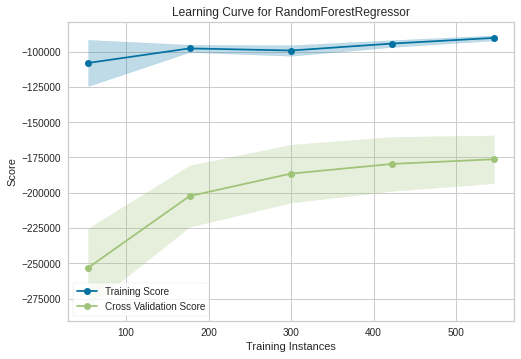

ValueError: ignored

TypeError: ignored

In [21]:
#from yellowbrick.model_selection import learning_curve

learning_curve(loaded_model, X_val, y_val, scoring='neg_mean_absolute_error')

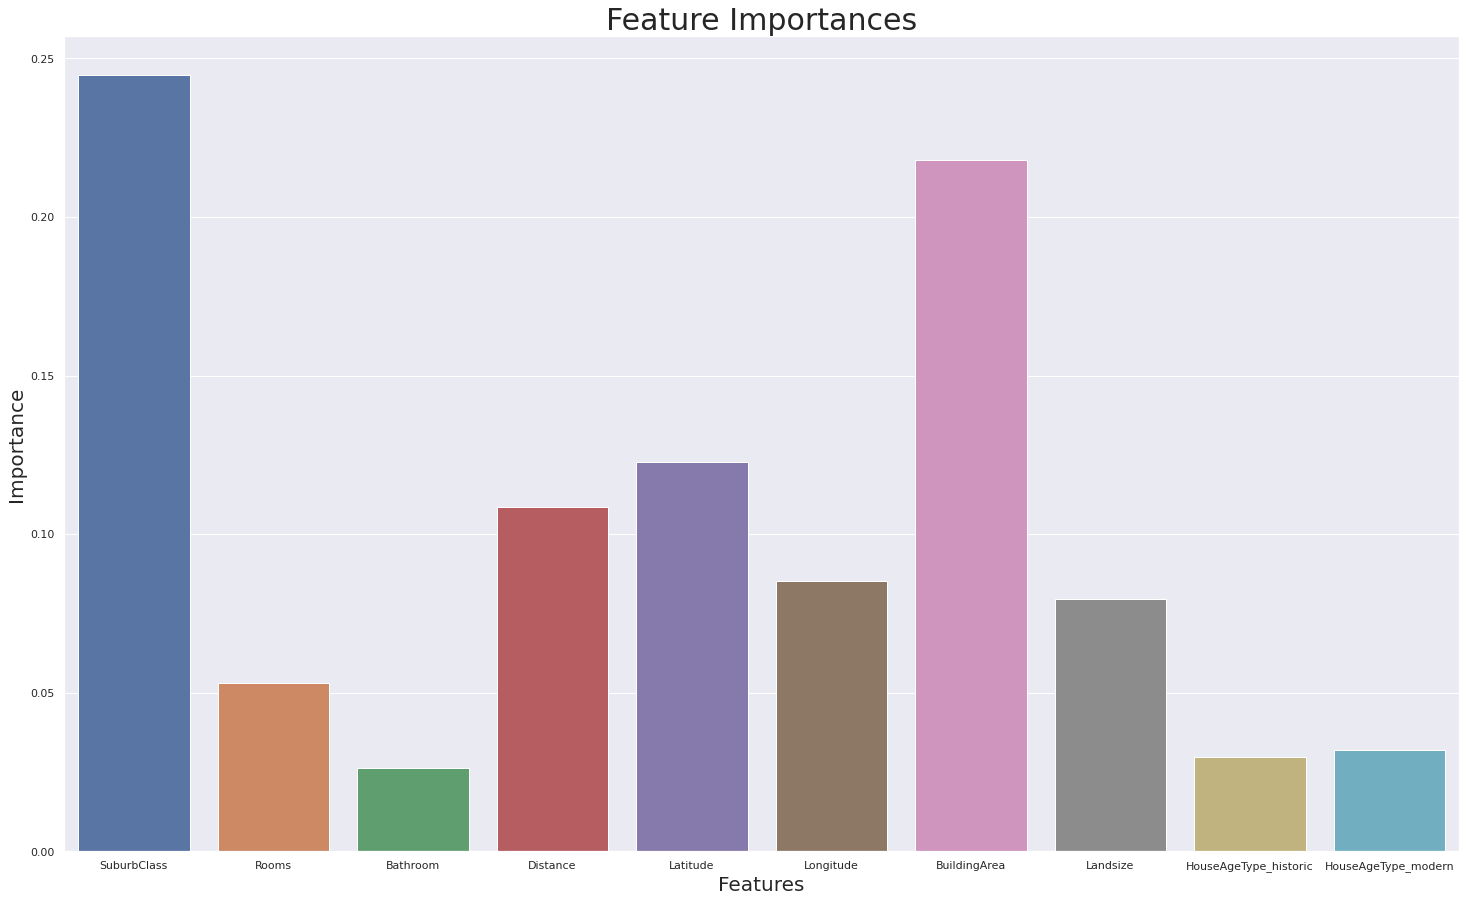

In [ ]:
# Feature importances

sb.set_theme(style='whitegrid')
sb.set(rc={'figure.figsize':(25,15)})

importance = loaded_model.feature_importances_
importances = pd.Series(loaded_model.feature_importances_,index=X_val.columns)

ax = sb.barplot(x=importances.index, y=importances.values)
ax.axes.set_title('Feature Importances',fontsize=30)
ax.set_xlabel('Features',fontsize=20)
ax.set_ylabel('Importance',fontsize=20)
ax.tick_params(labelsize=11)

In [92]:
runs_df.index = pd.to_datetime(runs_df.index) 
sorted_runs_df = runs_df.set_index('Start Time', drop=True, append=False, inplace=False, verify_integrity=False)
sorted_runs_df = sorted_runs_df.sort_index()
sorted_runs_df['mae'] = sorted_runs_df['mae'].apply(lambda x: int(x))

# For filling
sub_runs_df1 = sorted_runs_df['2022-02-23 18:43:41':'2022-03-01 16:47:41']
sub_runs_df2 = sorted_runs_df['2022-03-01 16:47:41':'2022-03-02 14:19:22']
sub_runs_df3 = sorted_runs_df['2022-03-02 14:19:22':'2022-03-05 00:04:30']
sub_runs_df4 = sorted_runs_df['2022-03-05 00:04:30':'2022-03-05 00:24:45']
#sorted_runs_df.to_csv('sorted_runs_df.csv', index=True)

In [ ]:
# First run 2022-02-23 18:43:41 (mae < 200.000 ca. 195.000)
# First big outlier 2022-03-01 10:21:33 (mae > 400.000)
# Dann sehr lange 177.000 -> ca. 190.000
# 2022-03-02 14:19:22 Index was removed/fixed as feature -> mae went to 190.000/200.000+ with some drops and in general high fluctuation 
# 2022-03-04 15:29:11 Dann wieder recht ähnlich eingependelt/normalisiert, aber etwas höher als vor Index removal
# 2022-03-05 00:04:30 Outlier wurden removed und zwei Features wieder ins Model eingebunden -> mae =< 150.000
# 2022-03-05 00:24:45 Last and best mae = 147.051

# Layout
fig, ax = plt.subplots()
ax.set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Plots

metrics_plot = plt.plot(sorted_runs_df.index, sorted_runs_df['mae'])

plt.fill_between(sub_runs_df1.index, sub_runs_df1['mae'], color='mediumpurple')
vline1 = plt.vlines(sorted_runs_df.loc['2022-03-01 16:47:41'].name, 0, sorted_runs_df.loc['2022-03-01 16:47:41']['mae'], color='red')
plt.fill_between(sub_runs_df2.index, sub_runs_df2['mae'], color='lightsteelblue')
vline2 = plt.vlines(sorted_runs_df.loc['2022-03-02 14:19:22'].name, 0, sorted_runs_df.loc['2022-03-02 14:19:22']['mae'], color='red')
plt.fill_between(sub_runs_df3.index, sub_runs_df3['mae'], color='peachpuff')
vline3 = plt.vlines(sorted_runs_df.loc['2022-03-05 00:04:30'].name, 0, sorted_runs_df.loc['2022-03-05 00:04:30']['mae'], color='red')
plt.fill_between(sub_runs_df4.index, sub_runs_df4['mae'], color='lightgreen')

#metrics_plot.tick_params(axis='x', rotation=90)

# am anfang outlier dann normal dann index removed -> steigt nach oben -> dann weiter trainiert normal -> dann features hinzugefügt und großer drop

# **Demo predictions**

In [ ]:
# Function to randomly predict prices with more details
def select_random_pred(n):
  indices = random.sample(range(0, len(X_test)), n)
  tb_predicted = X_test.iloc[indices]
  true_labels = np.take(y_test, indices)
  compared_list = []
  for i in range(0, len(tb_predicted)):
    compared_list.append(calc_prob(tb_predicted.iloc[i]))
  predictions = loaded_model.predict(tb_predicted)
  for e in range(0, len(tb_predicted)):
    print(f'{e+1}. Prediction:')
    print(f'The properties building area lies {abs(compared_list[e][0])}%{check_pos_neg(compared_list[e][0], 0)} the mean.') #{above/below} if minus -> below -> then remove minus
    print(f'Distance to city center was {abs(compared_list[e][1])}km{check_pos_neg(compared_list[e][1], 1)} the average.') #{lower, higher}
    print(f'And lastly the amount of rooms counted to {abs(compared_list[e][2])}{check_pos_neg(compared_list[e][2], 0)} standard.') #{above, below}
    print(f'Predicted price: {round(predictions[e])}$')
    print(f'Actual price: {round(true_labels[e])}$')
    print(f'Mean absolute error: {abs(round(true_labels[e]-predictions[e]))}$\n')
  
select_random_pred(7)

# **Sample Decision Tree**

The following plot display the complexity of a sample decision tree from the random forest model.

For a more detailed view open the *'sample_tree.png'*

In [ ]:
plt.figure(figsize=(200,100))  
_ = tree.plot_tree(loaded_model.estimators_[0], feature_names = X_val.columns, # ???????????? variablen name
             filled=True, fontsize=6, rounded = True)
plt.savefig('sample_tree.png')
plt.show()